#CNN/LSTM model

In [1]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

Dowload data

In [2]:
drive.mount('/content/gdrive')

#import time series
sp500_data = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/sp500_data.csv', index_col=0)
sp500_data = sp500_data.iloc[2:] #remove the first 2 rows that don't contain the time series
sp500_data.index.name = 'Date'
sp500_data.index = pd.to_datetime(sp500_data.index)

#save Close price and Log Returns into a pd.Series
Close_price = sp500_data['Close'].copy().astype(float)
Log_return = sp500_data['Log Return'].copy().astype(float)

#drop columns not needed
sp500_data.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Log Return'], axis=1, inplace=True)

#import ARIMA residuals
residuals = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/close_price_residuals.csv', index_col=0)
sp500_data.insert(0, 'Residuals', residuals.values)

#import ARIMA fitted values (predictions on the training set)
fitted_values = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/fitted_values.csv', index_col=0)

#import ARIMA predictions on the test set
ARIMA_predictions = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/arima_predictions.csv', index_col=0).squeeze() #to read it as a pd.Series
ARIMA_predictions.index = pd.to_datetime(ARIMA_predictions.index)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Helper functions to move data to the GPU

In [3]:
#define some helper classes
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    return device

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, torch.Tensor):  # Only move tensors to the device
        return data.to(device, non_blocking=True)
    else:
        return data  # For non-tensor types (e.g., strings), return as is


class DeviceDataLoader (): #receive a dataloader and move to the correct device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, device)

  def __len__(self):
    return len(self.dl)


#get device
device = get_device()

##Feature Engineering (multivariate sliding windows)

In [4]:
#time features
sp500_data['Year'] = sp500_data.index.year #this will be treated as a numerical feature

#those will be treated as categorical features
sp500_data['Month'] = sp500_data.index.month
sp500_data['Day'] = sp500_data.index.day
sp500_data['Day_of_week'] = sp500_data.index.dayofweek
sp500_data['Quarter'] = sp500_data.index.quarter
# sp500_data['Index_hash'] = sp500_data.index.map(lambda x: hash(x))


#lag features
for lag in (1,5,10,25,365):
  sp500_data[f'lag_{lag}'] = sp500_data['Residuals'].shift(lag)


#rolling features
for window in (5,10,25):
  sp500_data[f'rolling_mean_Residuals_{window}'] = sp500_data['Residuals'].shift(1).rolling(window=window).mean() #shift by one because the current close price won't be available at the day of the prediction
  sp500_data[f'rolling_std_Residuals_{window}'] = sp500_data['Residuals'].shift(1).rolling(window=window).std()
  sp500_data[f'rolling_skew_Residuals_{window}'] = sp500_data['Residuals'].shift(1).rolling(window=window).skew()
  sp500_data[f'rolling_mean_volume_{window}'] = sp500_data['Volume'].shift(1).rolling(window=window).mean()
  sp500_data[f'rolling_std_volume_{window}'] = sp500_data['Volume'].shift(1).rolling(window=window).std()
  sp500_data[f'rolling_skew_volume_{window}'] = sp500_data['Volume'].shift(1).rolling(window=window).skew()


#substitute NaN values with 0
sp500_data.fillna(0, inplace=True)


#visualize
sp500_data.columns

Index(['Residuals', 'Volume', 'Year', 'Month', 'Day', 'Day_of_week', 'Quarter',
       'lag_1', 'lag_5', 'lag_10', 'lag_25', 'lag_365',
       'rolling_mean_Residuals_5', 'rolling_std_Residuals_5',
       'rolling_skew_Residuals_5', 'rolling_mean_volume_5',
       'rolling_std_volume_5', 'rolling_skew_volume_5',
       'rolling_mean_Residuals_10', 'rolling_std_Residuals_10',
       'rolling_skew_Residuals_10', 'rolling_mean_volume_10',
       'rolling_std_volume_10', 'rolling_skew_volume_10',
       'rolling_mean_Residuals_25', 'rolling_std_Residuals_25',
       'rolling_skew_Residuals_25', 'rolling_mean_volume_25',
       'rolling_std_volume_25', 'rolling_skew_volume_25'],
      dtype='object')

Encode categorical features

In [5]:
#cyclical encoding to reflect the periodic nature of the categorical features (https://stackoverflow.com/questions/58936445/whats-the-proper-way-to-present-numerical-categorical-data-specifically-hour-o)
sp500_data['month_sin'] = np.sin(2 * np.pi * sp500_data['Month'] / 12)
sp500_data['month_cos'] = np.cos(2 * np.pi * sp500_data['Month'] / 12)

sp500_data['day_sin'] = np.sin(2 * np.pi * sp500_data['Day'] / 31)
sp500_data['day_cos'] = np.cos(2 * np.pi * sp500_data['Day'] / 31)

sp500_data['day_of_week_sin'] = np.sin(2 * np.pi * sp500_data['Day_of_week'] / 5)
sp500_data['day_of_week_cos'] = np.cos(2 * np.pi * sp500_data['Day_of_week'] / 5)

sp500_data['quarter_sin'] = np.sin(2 * np.pi * sp500_data['Quarter'] / 4)
sp500_data['quarter_cos'] = np.cos(2 * np.pi * sp500_data['Quarter'] / 4)


#numerical / categorical columns
num_cols = [
       'lag_1', 'lag_5', 'lag_10', 'lag_25', 'lag_365',
       'rolling_mean_Residuals_5', 'rolling_std_Residuals_5',
       'rolling_skew_Residuals_5', 'rolling_mean_volume_5',
       'rolling_std_volume_5', 'rolling_skew_volume_5',
       'rolling_mean_Residuals_10', 'rolling_std_Residuals_10',
       'rolling_skew_Residuals_10', 'rolling_mean_volume_10',
       'rolling_std_volume_10', 'rolling_skew_volume_10',
       'rolling_mean_Residuals_25', 'rolling_std_Residuals_25',
       'rolling_skew_Residuals_25', 'rolling_mean_volume_25',
       'rolling_std_volume_25', 'rolling_skew_volume_25']
cat_cols = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'quarter_sin', 'quarter_cos']


#drop columns not needed
sp500_data.drop(['Month', 'Day', 'Day_of_week', 'Volume', 'Quarter'], axis=1, inplace=True)


#visualise
sp500_data

,Residuals,Year,lag_1,lag_5,lag_10,lag_25,lag_365,rolling_mean_Residuals_5,rolling_std_Residuals_5,rolling_skew_Residuals_5,...,rolling_std_volume_25,rolling_skew_volume_25,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,quarter_sin,quarter_cos
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.306564,2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,5.712682e-01,0.820763,0.000000,1.000000,1.000000e+00,6.123234e-17
2000-01-04,-56.446985,2000,-0.306564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,7.247928e-01,0.688967,0.951057,0.309017,1.000000e+00,6.123234e-17
2000-01-05,-60.496419,2000,-56.446985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,8.486443e-01,0.528964,0.587785,-0.809017,1.000000e+00,6.123234e-17
2000-01-06,-59.933922,2000,-60.496419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,9.377521e-01,0.347305,-0.587785,-0.809017,1.000000e+00,6.123234e-17
2000-01-07,-21.433871,2000,-59.933922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,9.884683e-01,0.151428,-0.951057,0.309017,1.000000e+00,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,288.792765,2024,315.280792,387.120069,493.011489,405.877631,-644.077896,396.591694,56.341513,-0.548087,...,1.195016e+09,1.474773,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.951057,0.309017,-2.449294e-16,1.000000e+00
2025-01-02,274.534470,2025,288.792765,451.913308,468.365536,422.735876,-643.699194,376.926234,74.657066,-0.133943,...,1.210424e+09,1.505368,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.587785,-0.809017,1.000000e+00,6.123234e-17
2025-01-03,347.276415,2025,274.534470,448.285888,288.739844,455.823366,-626.490156,341.450466,72.220274,0.901211,...,1.167135e+09,1.789773,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.951057,0.309017,1.000000e+00,6.123234e-17


###train val test split

In [6]:
#train / vall / test split
train_data = sp500_data.loc[: '2018']
val_data = sp500_data.loc['2019': '2021']
train_val_data = sp500_data.loc[: '2021']
test_data = sp500_data.loc['2022':]

Scale datasets

In [7]:
# Initialize scalers
train_scaler = StandardScaler()
train_val_scaler = StandardScaler()

# Fit scaler only to the train set (when predicting on the val set) and on the train + validation set (when predicting on the test set)
train_scaler.fit(train_data[num_cols])
train_val_scaler.fit(train_val_data[num_cols])

# Create a copy of the datasets
train_data_scaled = train_data.copy()
val_data_scaled = val_data.copy()
train_val_data_scaled = train_val_data.copy()
test_data_scaled = test_data.copy()

# Scale numerical features
train_data_scaled.loc[:, num_cols] = train_scaler.transform(train_data[num_cols])
val_data_scaled.loc[:, num_cols] = train_scaler.transform(val_data[num_cols])

# Scale numerical features for train+val set and test set
train_val_data_scaled.loc[:, num_cols] = train_val_scaler.transform(train_val_data[num_cols])
test_data_scaled.loc[:, num_cols] = train_val_scaler.transform(test_data[num_cols])


#scale target
train_target_scaler = MinMaxScaler(feature_range=(-1, 1))
train_val_target_scaler = MinMaxScaler(feature_range=(-1, 1))

train_data_scaled['Residuals'] = train_target_scaler.fit_transform(train_data['Residuals'].values.reshape(-1, 1))
val_data_scaled['Residuals'] = train_target_scaler.transform(val_data['Residuals'].values.reshape(-1, 1))

train_val_data_scaled['Residuals'] = train_val_target_scaler.fit_transform(train_val_data['Residuals'].values.reshape(-1, 1))
test_data_scaled['Residuals'] = train_val_target_scaler.transform(test_data['Residuals'].values.reshape(-1, 1))


#X, y split
X_train = np.array(train_data_scaled.drop(columns=['Residuals']))
y_train = np.array(train_data_scaled['Residuals'])
X_val = np.array(val_data_scaled.drop(columns=['Residuals']))
y_val = np.array(val_data_scaled['Residuals'])
X_train_val = np.array(train_val_data_scaled.drop(columns=['Residuals']))
y_train_val = np.array(train_val_data_scaled['Residuals'])
X_test = np.array(test_data_scaled.drop(columns=['Residuals']))
y_test = np.array(test_data_scaled['Residuals'])

In [8]:
y_train[0:10]

array([0.93781704, 0.88570949, 0.88195095, 0.88247304, 0.91820742,
       0.93533867, 0.91829915, 0.90812591, 0.92527256, 0.9414054 ])

Multivariate sliding windows

In [9]:
def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
      _x = data.iloc[i:i+seq_length, 1:]
      _y = data.iloc[i + seq_length, 0]
      X.append(_x)
      y.append(_y)

    return np.array(X), np.array(y)


#sliding windows
X_train, y_train  = sliding_windows(train_data_scaled, 1)
X_val, y_val= sliding_windows(val_data_scaled, 1)
X_test, y_test = sliding_windows(test_data_scaled, 5)
X_train_val , y_train_val = sliding_windows(train_val_data_scaled, 5)

Convert data into tensors

In [ ]:
#create a custom dataset
class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


#istance of the custom dataset class
train_df = Custom_df(X_train, y_train)
val_df = Custom_df(X_val, y_val)
train_val_df = Custom_df(X_train_val, y_train_val)
test_df = Custom_df(X_test, y_test)


#create dataloaders (to perform training/inference in batch)
batch_size = 128
num_workers = 2

train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
train_val_loader = DataLoader(train_val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


#get device
device = get_device()


#move to device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
train_val_loader = DeviceDataLoader(train_val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

##Univariate sliding windows

In [4]:
#univariate sliding window
train_data = residuals.loc[: '2018']
train_data.index = pd.to_datetime(train_data.index)

val_data = residuals.loc['2019': '2021']
val_data.index = pd.to_datetime(val_data.index)

train_val_data = residuals.loc[: '2021']
train_val_data.index = pd.to_datetime(train_val_data.index)

test_data = residuals.loc['2022':]
test_data.index = pd.to_datetime(test_data.index)

# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data.values.reshape(-1, 1)))
val_data_scaled = pd.DataFrame(scaler.transform(val_data.values.reshape(-1, 1)))


def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
      _x = data.iloc[i:i+seq_length]
      _y = data.iloc[i + seq_length]
      X.append(_x)
      y.append(_y)

    return np.array(X), np.array(y)


#sliding windows
X_train, y_train  = sliding_windows(train_data_scaled, 10)
X_val, y_val= sliding_windows(val_data_scaled, 10)
X_test, y_test = sliding_windows(test_data, 10)
X_train_val , y_train_val = sliding_windows(train_val_data, 10)

Covert data into tensor

In [5]:
#create a custom dataset
class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


#istance of the custom dataset class
train_df = Custom_df(X_train, y_train)
val_df = Custom_df(X_val, y_val)
train_val_df = Custom_df(X_train_val, y_train_val)
test_df = Custom_df(X_test, y_test)


#create dataloaders (to perform training/inference in batch)
batch_size = 128
num_workers = 2

train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
train_val_loader = DataLoader(train_val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


#get device
device = get_device()


#move to device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
train_val_loader = DeviceDataLoader(train_val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [12]:
for batch in train_loader:
    x, y = batch  # Assuming batch contains (input, target)
    print(x.shape)  # Shape of the input tensor
    print(y.shape)  # Shape of the target tensor
    break

torch.Size([128, 1, 32])
torch.Size([128])


##LSTM CNN model

In [69]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension

class CNN_LSTM_model(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super().__init__() #initialize the parent class
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        batch_first=True) #This argument specifies the input and output tensors are provided as (batch, seq, feature)
    self.cnn = nn.Sequential(
        nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2),
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2),
        #flatten
        nn.Flatten(),
        nn.LazyLinear(out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=num_classes)
    )

  def forward(self, x):
    out, _ = self.lstm(x)  #stateless LSTM each batch is using a different hidden/cell state (initialized to 0)
    out = out.permute(0, 2, 1)
    out = self.cnn(out)
    # out = out.squeeze(-1)
    # print(out)
    return out

  def training_step(self, batch):
    x, y = batch
    out = self(x) # This calls self.forward(x) through the __call__ method
    #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
    loss = rmse_loss(out, y)
    return loss

  def validation_step(self, batch):
    x, y = batch
    out = self(x)
    #loss = torch.sqrt(F.mse_loss(out, y))
    loss = rmse_loss(out, y)
    return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    return {'val_loss': epoch_loss.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
num_classes = 1 # regression
# input_size = 32  # Number of features per time step
input_size = 1 #number of input features
hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
num_layers = 1

model = CNN_LSTM_model(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
model.to(device) #move the istance to the device

CNN_LSTM_model(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [6]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.batch_size = batch_size

        #network layers
        self.dropout = nn.Dropout(p=0.2)
        self.lstm = nn.LSTM(input_size=input_size, #input features
                            hidden_size=hidden_size,  #number of features in the hidden state
                            num_layers=num_layers, #how many stacked LSTM layers
                            batch_first=True, #This argument specifies the input and output tensors are provided as (batch, seq, feature)
                            dropout = 0.25) #25% of the output units will be randomly set to zero
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)  # Initialize hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)  # Initialize cell state


        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0)) #ula is the output of the LSTM for all time steps, h_out is the hidden state output from the last layer of the LSTM for the last time step, which will be used for classification. _ is the cell state (not used here, hence the underscore).

        h_out = h_out.view(-1, self.hidden_size) #for a multi-layer LSTM, h_out returns the hidden states for each layer at the last time step for each sequence in the batch. the hidden state is therefore flatened to to ensure it has a shape suitable for the fully connected layer.

        out = self.fc(h_out)
        out = self.dropout(out) #dropout layer to reduce overfitting
        # print(out)
        # out = out.squeeze(-1)

        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
num_classes = 1 # regression
# input_size = 32  # Number of features per time step
input_size = 1 #number of input features
hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
num_layers = 1

model = LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
model.to(device) #move the istance to the device

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


LSTM(
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(1, 512, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

##Training

In [7]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, lr, model, train_loader, val_loader, warmup_epochs, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache() #clear the unused memory from the GPU
    history = []

    optimizer = opt_func(model.parameters(), lr, weight_decay= weight_decay) #updates the model weights according to the learnign rate

    # Warm-up scheduler (linear increase of the learning rate during warm-up)
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1)

    #Annealing scheduler (decrease the lr after the warm-up)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          patience=5, #defines how many epochs to wait for an improvement
                                                          factor =0.5 , #factor by which the learning rate will be reduced
                                                          min_lr=1e-7, #sets the minimum learning rate that the scheduler can reach
                                                          eps=1e-08) #small value added to the learning rate for numerical stability

    for epoch in range(epochs):
        model.train()
        train_losses =[]
        lrs = []

        for batch in train_loader:
        #training loop
            input, output = batch
            loss = model.training_step(batch)
            #print(f"batch loss: {loss}")
            # print(input)
            # print(out)
            train_losses.append(loss)
            loss.backward() #compute gradients

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip) #gradient clippping

            optimizer.step() #update weights
            optimizer.zero_grad() #reset gradients

        #update lr
        if epoch < warmup_epochs:
            warmup_scheduler.step()
            if epoch == 0:
                print("warmup phase")
        else:
            scheduler.step(result['val_loss'])
            if epoch == warmup_epochs:
                print("annealing phase")

        #track lr
        lrs.append(get_lr(optimizer))

        #validation loop
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        #scheduler.step(result['val_loss'])


        model.epoch_end(epoch, result) #print results
        history.append(result)

    return history

In [8]:
import time

#evaluate untrained model
history = [evaluate(model, test_loader)]

#train model
epochs = 200
max_lr = 0.001
grad_clip = None
weight_decay = 1e-5
opt_func = torch.optim.Adam
warmup_epochs = 10

start_time = time.time()
history += fit(epochs, max_lr, model, train_loader, val_loader, warmup_epochs, weight_decay, grad_clip, opt_func)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

warmup phase
Epoch [0], last_lr: 0.00020, train_loss: 0.2238, val_loss: 0.0967
Epoch [1], last_lr: 0.00030, train_loss: 0.1425, val_loss: 0.0300
Epoch [2], last_lr: 0.00040, train_loss: 0.0733, val_loss: 0.0155
Epoch [3], last_lr: 0.00050, train_loss: 0.0610, val_loss: 0.0194
Epoch [4], last_lr: 0.00060, train_loss: 0.0501, val_loss: 0.0210
Epoch [5], last_lr: 0.00070, train_loss: 0.0476, val_loss: 0.0234
Epoch [6], last_lr: 0.00080, train_loss: 0.0584, val_loss: 0.0252
Epoch [7], last_lr: 0.00090, train_loss: 0.1165, val_loss: 0.0277
Epoch [8], last_lr: 0.00100, train_loss: 0.0905, val_loss: 0.0194
Epoch [9], last_lr: 0.00100, train_loss: 0.0600, val_loss: 0.0119
annealing phase
Epoch [10], last_lr: 0.00100, train_loss: 0.0502, val_loss: 0.0133
Epoch [11], last_lr: 0.00100, train_loss: 0.0501, val_loss: 0.0153
Epoch [12], last_lr: 0.00100, train_loss: 0.0664, val_loss: 0.0201
Epoch [13], last_lr: 0.00100, train_loss: 0.0583, val_loss: 0.0112
Epoch [14], last_lr: 0.00100, train_loss: 0

##Batch inference

In [9]:
#helper function to make inference with batches
@torch.no_grad()
def inference(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    for batch in data_loader:
        input, output = batch  # Unpack your batch into input and output
        outputs = model(input) # Perform the forward pass

        # Move outputs and actuals back to CPU and append to lists
        predictions.append(outputs.cpu())
        actuals.append(output.cpu())

    # Concatenate all predictions and actuals into single tensors
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)

    return predictions, actuals

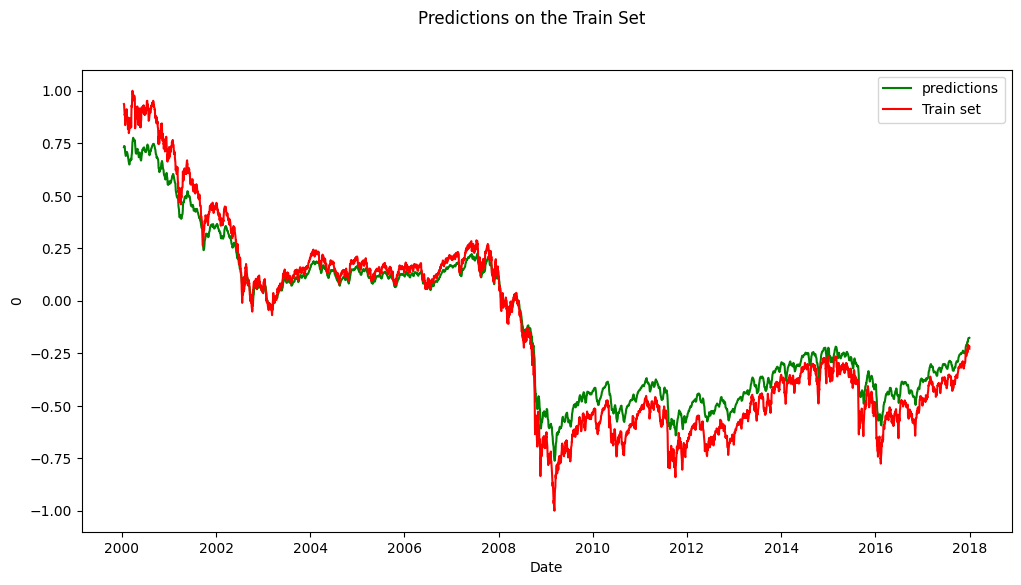

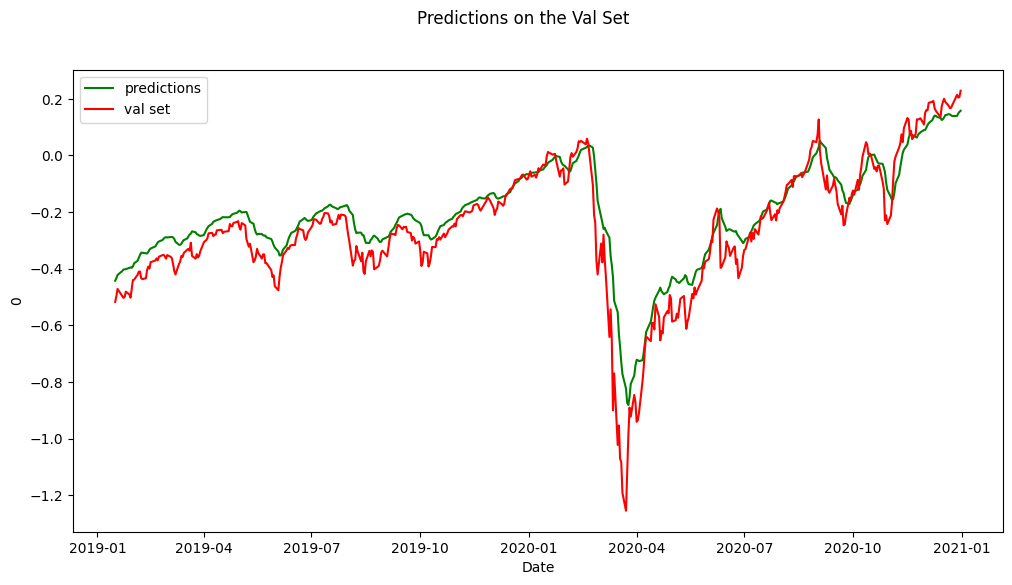

In [10]:
#batch inference
prediction, actual = inference(model, val_loader)


#predictions on the val_loader
prediction = pd.DataFrame(prediction)
prediction.index = val_data[10:].index
actual = pd.DataFrame(actual)
actual.index = val_data[10:].index


#predictions on the train_loader
train_predictions, actual_train = inference(model, train_loader)
train_predictions = pd.DataFrame(train_predictions)
train_predictions.index = train_data[10:].index
actual_train = pd.DataFrame(actual_train)
actual_train.index = train_data[10:].index


#visualize
#predictions on the train set
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_predictions.index, y = train_predictions[0], color = "green", label = "predictions")
sns.lineplot(x=actual_train.index, y = actual_train[0], color = "red", label = "Train set")
plt.suptitle('Predictions on the Train Set')
plt.show()


#predictions on the val set
plt.figure(figsize=(12, 6))
sns.lineplot(x=prediction.index, y = prediction[0], color = "green", label = "predictions")
sns.lineplot(x=actual.index, y = actual[0], color = "red", label = "val set")
plt.suptitle('Predictions on the Val Set')
plt.show()




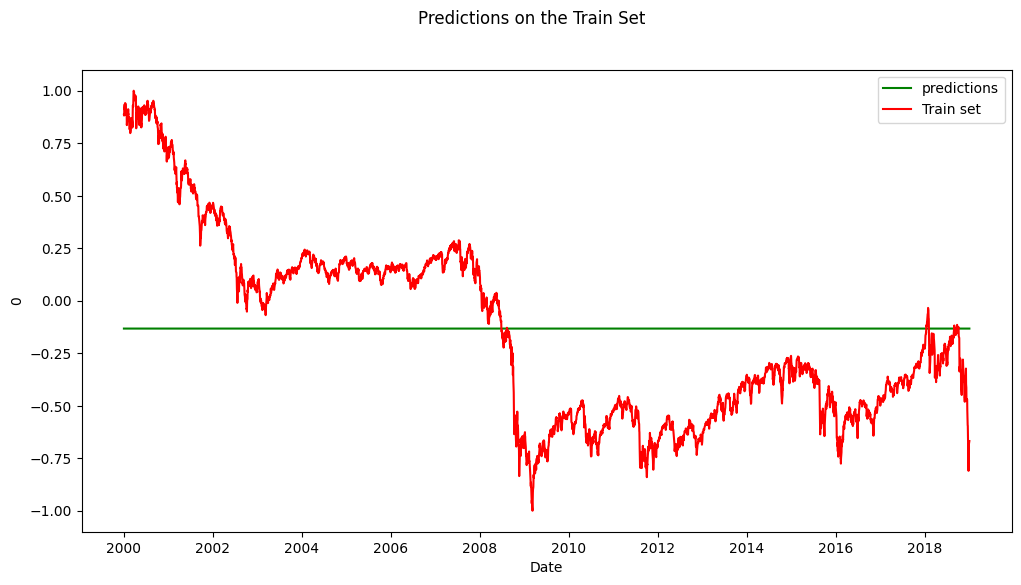

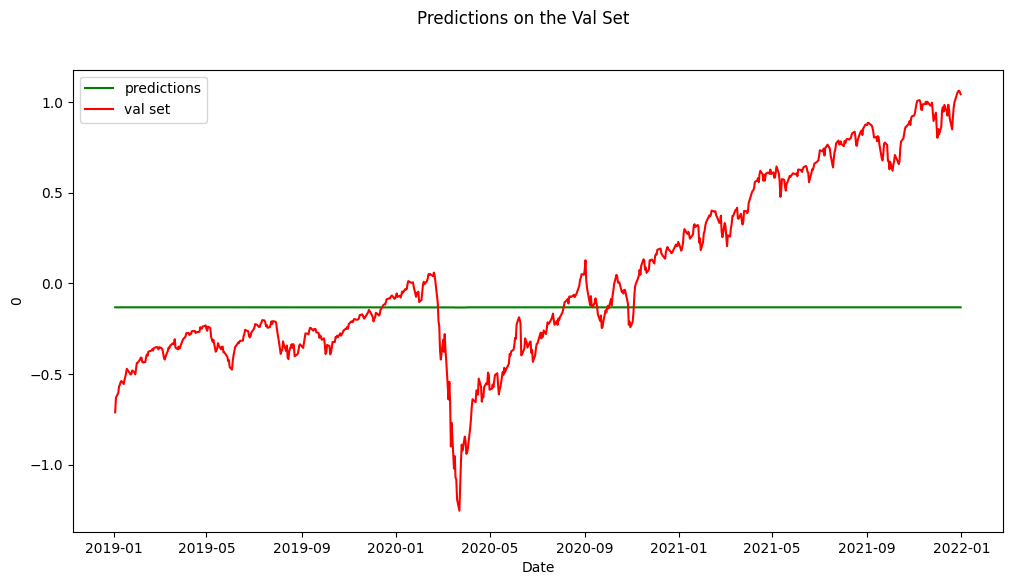

In [20]:
#batch inference
prediction, actual = inference(model, val_loader)


#predictions on the val_loader
prediction = pd.DataFrame(prediction)
prediction.index = val_data[1:].index
actual = pd.DataFrame(actual)
actual.index = val_data[1:].index


#predictions on the train_loader
train_predictions, actual_train = inference(model, train_loader)
train_predictions = pd.DataFrame(train_predictions)
train_predictions.index = train_data[1:].index
actual_train = pd.DataFrame(actual_train)
actual_train.index = train_data[1:].index


#visualize
#predictions on the train set
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_predictions.index, y = train_predictions[0], color = "green", label = "predictions")
sns.lineplot(x=actual_train.index, y = actual_train[0], color = "red", label = "Train set")
plt.suptitle('Predictions on the Train Set')
plt.show()


#predictions on the val set
plt.figure(figsize=(12, 6))
sns.lineplot(x=prediction.index, y = prediction[0], color = "green", label = "predictions")
sns.lineplot(x=actual.index, y = actual[0], color = "red", label = "val set")
plt.suptitle('Predictions on the Val Set')
plt.show()

